# Text Analysis and Topic Modeling Project


For this project we will be working with a dataset of over 400,000 quora questions that have no labeled cateogry. First we will look into some features of the text, as their length, POS distribution, NERs etc. by means of Spacy library. Then we will attempt to find cateogries to assign these questions to with the help of sklearn tools. For this we will use embeddings.


Let's import all the libraries we will need.

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import random

import spacy
from spacy import displacy

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

Our data will be stored in the file named 'data'.

In [2]:
data = pd.read_csv('quora_questions.csv')

In [3]:
data.head()

,Question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404289 entries, 0 to 404288
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Question  404289 non-null  object
dtypes: object(1)
memory usage: 3.1+ MB


So, we have one column with questions and 404,289 entires. In the Info table we couldn't see any nan values, however some spaces may be present which are not detected as missing values. Therefore, we should check whether we have such entries.


In [5]:
blanks = []  # start with an empty list

for i,q in data.itertuples():  # iterate over the DataFrame
    if type(q)==str:            # avoid NaN values
        if q.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list

data.drop(blanks, inplace=True)

In [6]:
blanks

[]

No spaces have been found, so let's continue with the analysis.

## Analysis

In order to be able to conduct the analysis we will be using Spacy library with the extensive set of features it provides. Hopefully, medium-size model of English will be enough for our purposes.

In [7]:
#!python -m spacy download en_core_web_md

In [8]:
nlp = spacy.load('en_core_web_md')

Once the model is downloaded, we apply it's capabilities to process all the questions we have. The Spacy model tokenizes texts, attributes POS tags, finds NERS and creates text vectors.

In [9]:
data_nlp = pd.DataFrame() # new dataframe will store processed texts

data_nlp['Question'] = data['Question'].apply(lambda x: nlp(x)) # process texts
data_nlp['NumOfWords'] = data_nlp['Question'].apply(lambda x: len(x)) # create a column with the number of tokens
data_nlp['NumOfSents'] = data_nlp['Question'].apply(lambda x: len([sent for sent in x.sents])) # create a column with the number of sentences

Now, let's look at the distribution of the questions' lengths. This will help us to identify abnormalities.

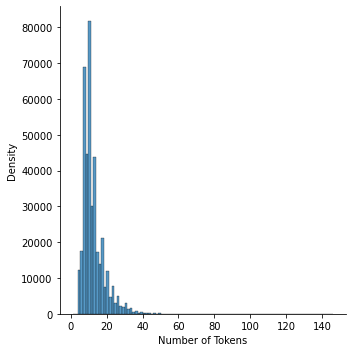

In [10]:
ax_w = sns.displot(data_nlp['NumOfWords'], bins=100)
ax_w.set_axis_labels('Number of Tokens', 'Density')
ax_w.set_titles('Number of Tokens per Text')
plt.show()

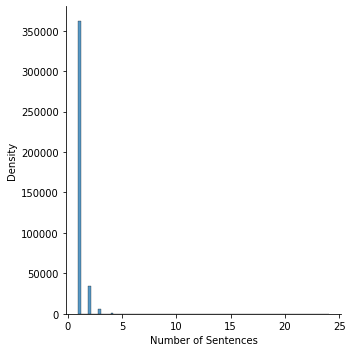

In [11]:
ax_s = sns.displot(data_nlp['NumOfSents'], bins=100)
ax_s.set_axis_labels('Number of Sentences','Density')
ax_s.set_titles('Number of Sentences per Text')
plt.show()

As the graphs show, the dataset contains both very short questions (less than 3 tokens in length) and very long (around 140 tokens). While, presumably, the short ones should be deleted for hardly bearing any usefull information, the situation with the long ones is not that straightforward. So, let's look at both groups.

In [12]:
less_than_three = data_nlp[data_nlp['NumOfWords'] < 3]
print(len(less_than_three))
less_than_three.head(10)

79


,Question,NumOfWords,NumOfSents
3306,(.),1,1
13016,(?),1,1
17682,(deleted),1,1
20794,(?),1,1
23305,(deleted),1,1
23884,(HH),1,1
25228,"(What, ?)",2,1
25315,(deleted),1,1
39769,(deleted),1,1
44619,(Na),1,1


In [13]:
data_nlp[data_nlp['NumOfSents'] > 8]

,Question,NumOfWords,NumOfSents
8201,"(Z=(1, ^, 2, ), -, (, 2, ^, 2, ), +, (, 3, ^, ...",44,10
101231,"(What, is, C@ll, USA~*(1, ), _, (, 877, ), _, ...",28,9
115110,"(〽, Can, anybody, solve, this, ...., , ⚪, +,...",39,16
147457,"(I, broke, up, with, him, ., I, love, him, so,...",82,9
187647,"(I, am, currently, in, 11th, standard, and, I,...",64,9
244614,"(What, do, I, do, ?, M, a, average, student, j...",34,9
246554,"(What, is, C@ll, USA~*(1, ), _, (, 877, ), _, ...",28,9
257594,"(How, can, I, rewrite, the, URL, "", index, ., ...",46,9
290090,"(रिक्त, स्थान, भरो, :, -एक, _, _, _, _, _, औरत...",55,24
304164,"(Can, anybody, solve, this, …, ⚪, +, ⚪, +, ⚪, ...",33,15


In [14]:
longest = data_nlp['Question'][data_nlp[data_nlp['NumOfWords'] == data_nlp['NumOfWords'].max()].index[0]]
longest

Like everyone else (here in U.S), I work with a group of people I see and interact with every day. As a human rights advocate and Lesbian, my views are liberal and I by no means preach my beliefs in my work place. However, I want to know, when is it OK to state your opinions on an issue. For example, if someone mentions that their next door neighbor, who happens to be a 12 year old boy, was playing with dolls and that "this is going down the wrong road and he is strange/weird", is it OK for me to say that we shouldn't judge him for who he is? So confused... This just happened at lunch and I am very upset about it...

Apparently, we need to drop all the entries, containig less than 3 tokens. As for the long ones, we will drop all the duplicates and all that do not contain English words.

In [15]:
data = data.drop(less_than_three.index).reset_index(drop=True)
data_nlp = data_nlp.drop(less_than_three.index).reset_index(drop=True)

In [16]:
duplicates = data[data.duplicated()]
print(len(duplicates))
duplicates.head()

113801


,Question
264,Why do Slavs squat?
1081,Did Trump win the election?
1429,Which are the best movies of 2016?
1467,Why do Trump supporters believe that Donald Tr...
1567,How can changing 500 and 1000 rupee notes end ...


We have a lot of duplicates (near to a one-fourth of the dataframe), however we should delete them, as these are useless.

In [17]:
data = data.drop(duplicates.index).reset_index(drop=True)
data_nlp = data_nlp.drop(duplicates.index).reset_index(drop=True)

In [18]:
data_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290409 entries, 0 to 290408
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Question    290409 non-null  object
 1   NumOfWords  290409 non-null  int64 
 2   NumOfSents  290409 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.6+ MB


Now we have 290,409 entries. Among the longest sentences in the dataset we've seen some that are written in some other language than English. As we analyse only English here, let's delete such texts as well.

In [19]:
pattern = re.compile(r'[a-zA-Z]')
no_english = []

for ind,quest in data.iterrows():
    if pattern.search(quest[0]) is None:
        no_english.append(ind)
print(len(no_english))

3


In [20]:
data_nlp = data_nlp.drop(no_english).reset_index(drop=True)

Okay, done. Now let's look at the distribution of parts of speech in the dataset. In order to do this, we will create a dictionary, containing tags of the parts of speech and the number of times they occur in the dataset.

In [21]:
def merge_dict(dict1, dict2): # merge two dictionaries
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items(): 
        if key in dict1 and key in dict2:
            dict3[key] = value + dict1[key] # sum their values by similar key
    return dict3

In [22]:
POS_per_quest = [quest.count_by(spacy.attrs.POS) for quest in data_nlp['Question']] # create dictionary for each question

POS_counts = {}

for i in range(len(POS_per_quest)-1): # merge all the dicts to one
    POS_counts = merge_dict(POS_counts, POS_per_quest[i])

In [23]:
for k,v in sorted(POS_counts.items(), key=lambda item: item[1], reverse=True):
    print(f'{k}. {longest.vocab[k].text:{5}}: {v}')

92. NOUN : 670416
97. PUNCT: 417763
100. VERB : 379016
90. DET  : 343467
87. AUX  : 317367
85. ADP  : 304801
95. PRON : 299552
96. PROPN: 280532
84. ADJ  : 243232
86. ADV  : 191093
94. PART : 77657
89. CCONJ: 70691
98. SCONJ: 45118
93. NUM  : 44111
99. SYM  : 8825
101. X    : 2846
91. INTJ : 1931
103. SPACE: 587


As our counter shows, the most frequent POS are noun, verb and determiner. Let's look at our longest sentence again and find some Named Entities within it.

In [24]:
displacy.render(longest, style='ent', jupyter=True)

Well, all the entities have been found. Here we can observe that Spacy is capable of identifying a wide range of entities, includind not only geographical spots and dates, but also social or political groups. Below we will count the most common entities of the dataset. 

In [25]:
entities_dict = Counter() # create a counter for entities

for text in data_nlp['Question']:
    if len(text.ents) > 0:
        for ent in text.ents:
            entities_dict[ent.text] += 1

In [26]:
entities_dict.most_common(20)

[('India', 8742),
 ('Quora', 4351),
 ('Indian', 2737),
 ('one', 2720),
 ('US', 2243),
 ('first', 2073),
 ('English', 1825),
 ('2016', 1714),
 ('Facebook', 1676),
 ('Google', 1311),
 ('Donald Trump', 1254),
 ('China', 1244),
 ('Android', 1154),
 ('two', 1138),
 ('USA', 1061),
 ('Trump', 1041),
 ('Instagram', 940),
 ('iPhone', 915),
 ('Pakistan', 857),
 ('2', 845)]

So, the most frequent entities are countries, numbers and organisations. 

Moreover, the language model that we've downloaded by means of Spacy contains word vectors for large amount of English words. Word vector is a way of positioning a word in a high-dimensional space so to convey it's meaning. We can test this function by checking, for example, how 'US', 'USA' and 'U.S.' are similar.

In [27]:
# Create a three-token Doc object:
tokens = nlp(u'US USA U.S.')

# Iterate through token combinations:
for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

US US 1.0
US USA 0.2922543
US U.S. 0.18034387
USA US 0.2922543
USA USA 1.0
USA U.S. 0.60449594
U.S. US 0.18034387
U.S. USA 0.60449594
U.S. U.S. 1.0


So, the most similar vectors are U.S. and USA. Strangely, US is not really similar to any of those. Perhaps, it's because the vector that is taken here is for the word 'us'.

## Training

Further, we will create a dataset consisting of text (question) vectors. Text vector in Spacy is created by taking a mean vector of all vectors for tokens present in the text. After that, we will try to divide questions in topics on the basis of their vectors.

In [28]:
data_vectorized = [] # vectors go here

for quest in data_nlp['Question']:
    data_vectorized.append(quest.vector)

In [29]:
data_vectorized = np.array(data_vectorized)
data_vectorized.shape

(290406, 300)

It would be useful to look at an approximate location of each question in a given space, because this could help us to decide on the number of categories representing our data. However the vectors are far too big to be plotted. We can use TruncatedSVD tool to reduce vectors' dimensions to 2 in order to locate them on a map.

In [30]:
# Reduce a matrix consisting of text vectors of 300 dimensions to 2 dimensions
def reduce_to_k_dim(data_vect, k=2):    
    n_iters = 10     
    data_reduced = None
    print("Running Truncated SVD over %i texts..." % (data_vect.shape[0]))

    trunc_SVD = TruncatedSVD(n_components=k, n_iter=n_iters)
    data_reduced = trunc_SVD.fit_transform(data_vect, y=None)    

    print("Done.")
    return data_reduced

In [31]:
data_reduced = reduce_to_k_dim(data_vectorized, k=2)

Running Truncated SVD over 290406 texts...
Done.


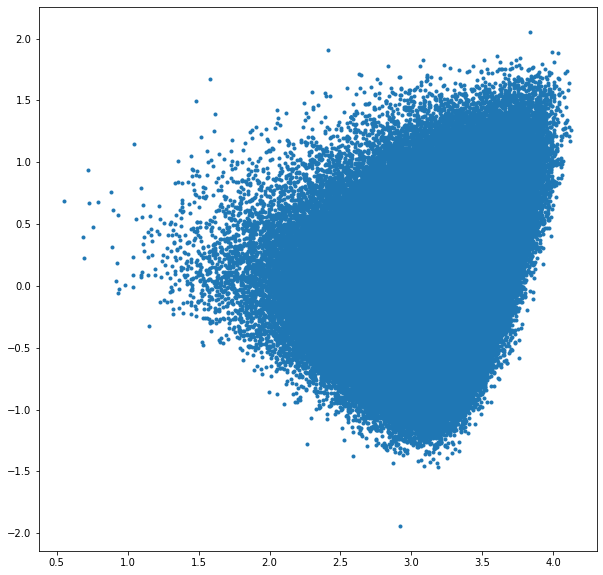

In [32]:
plt.figure(figsize=(10, 10))

plt.scatter(data_reduced.T[0], data_reduced.T[1], marker='.');

As the plot we got is just in fact a very rough approximation of embeddings, we can not distinguish any category except this one big spot. Thus we need to find out the number of categories by means of ML. In this project we will be using KMeans, which is able to define clusters with no need in prelabeled data. Let's try several different cluster numbers to understand which one can represent our data most thoroughly and with less distortion.

In [33]:
distortion = [] # this parameter can show what number of clusters could fit our data the most 

for k in range(10, 31, 5):
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(data_vectorized)
    distortion.append(model.inertia_) 

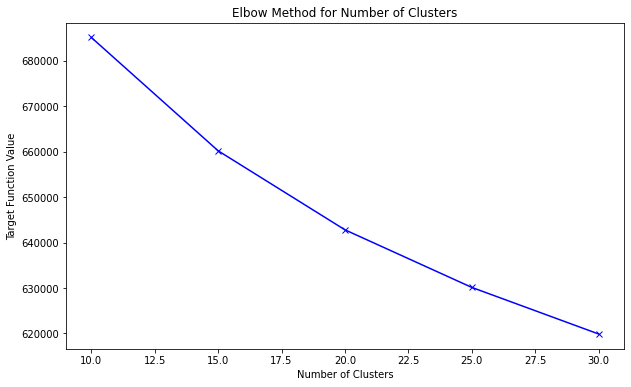

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(range(10, 31, 5), distortion, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Target Function Value')
plt.title('Elbow Method for Number of Clusters')
plt.show() 

As we can see, even 30 clusters are may not be enough to cover all the topics we have (target function haven't converged to 0). However, we will not make things complex and will settle upon 30 clusters. Let's create a new datafreme with questions, their coordinates and categories. After that we'll check, what the most common words for each category are.

In [35]:
# Creation of a new dataset
data_new = pd.DataFrame(data_reduced, columns = ['X', 'Y'])
data_new['Question'] = data_nlp['Question']
data_new['Category'] = model.labels_

In [36]:
# Creation of a dictionary with the most frequent words
words_dict = {} # create a counter for words

for i in range(model.n_clusters): # create a dictionary with word frequencies for each defined category
  cluster = data_new[data_new['Category'] == i]['Question']
  cluster_dict = Counter()
  for text in cluster:
      for token in text:
        if not token.is_punct and not token.is_stop:
          cluster_dict[token.text] += 1
  words_dict[i] = sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)[:21] # take top 20 words with their frequencies

Now, as we have a dictionary with word frequencies, let's visualize our results and check, if our algorithm worked well.

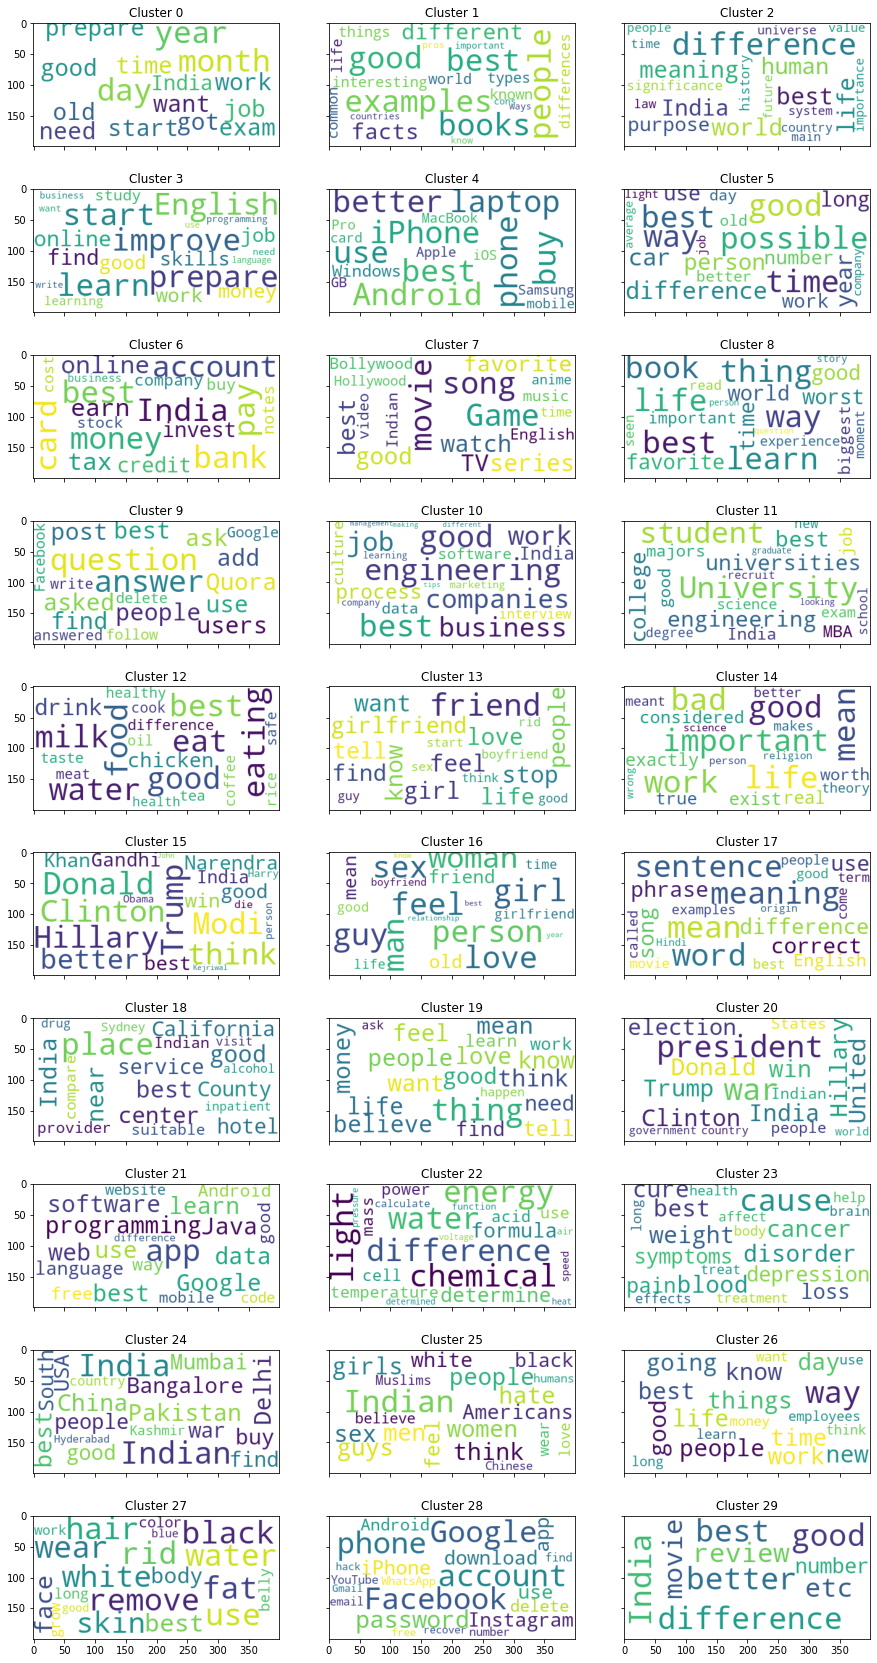

In [38]:
# Visualisation of top 20 words for each category

top20_words = {}

for cluster, all_words in words_dict.items():
  top20_words[cluster] = (" ").join([word_pack[0] for word_pack in all_words])

fig, axs = plt.subplots(10, 3, sharex=True, sharey=True, figsize=(15,30))

x=0
for i in range(10):
  for j in range(3):
    wordcloud = WordCloud(max_font_size=50, background_color="white").generate(top20_words[x])
    axs[i, j].imshow(wordcloud)
    axs[i, j].set_title(f"Cluster {x}")
    x += 1

plt.show()

Looking at the word clouds we can see some really meaningfull categories. For example, the Cluster 0 seems to be about some time related topics, Cluster 7 is about TV and shows, Cluster 15 is for questions on elections, and Cluster 28 is for social media accounts related requests.

**Summary**

All in all, text embeddings in combination with KMeans give quite a good result on unsupervised clusterisation of questions from Quora. There are some things worth more thorough investigation, as more precise number of categories and why India appears in so many topics :)